In [1]:
# Custom libraries
from libraries.dataPreprocessing import *
from libraries.snnNetwork import *
from libraries.datasetLoader import *

# Pytorch imports
from torch.utils.data import DataLoader

# Matplotlib imports
import matplotlib.pyplot as plt 
import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

# Parse .csv files
import pandas as pd

# Script options
import getopt
import sys

In [2]:
# File paths
sourceFile = './datasets/iris/iris.data'
saveFile = './processedData/iris.data'
networkFile = './networks/irisNetwork.pt'

In [3]:
# Data characteristics
variablePositions = [0, 1, 2, 3]
resultPosition = 4
resultEncoding = {
  "Iris-setosa": "0",
  "Iris-versicolor": "1",
  "Iris-virginica": "2"
}

# Number of steps and batch size

In [4]:
num_steps = 100
batch_size = 5


# 1. Iris Dataset information

SOURCE: https://archive.ics.uci.edu/dataset/53/iris 

FROM: iris.names

1. Number of Instances: 150 (50 in each of three classes)
2. Number of Attributes: 4 numeric, predictive attributes and the class
3. Attribute Information:
   1. sepal length in cm
   2. sepal width in cm
   3. petal length in cm
   4. petal width in cm
   5. class: 
      - Iris Setosa
      - Iris Versicolour
      - Iris Virginica
4. Missing Attribute Values: None

Summary Statistics:
|                   | Min | Max | Mean | SD   | Class Correlation |
|-------------------|-----|-----|------|------|-------------------|
| sepal length:     | 4.3 | 7.9 | 5.84 | 0.83 | 0.7826            |
| sepal width:      | 2.0 | 4.4 | 3.05 | 0.43 | -0.4194           |
| petal length:     | 1.0 | 6.9 | 3.76 | 1.76 | 0.9490   (high!)  |
| petal width:      | 0.1 | 2.5 | 1.20 | 0.76 | 0.9565   (high!)  |

5. Class Distribution: 33.3% for each of 3 classes.

# 2. No-Gaussian receptive fields


## 2.1. Processing Data
In `processData` method, `gaussian=False`.

In [5]:
# Read data
elementSeparator = '\n'
parameterSeparator = ','

In [6]:
print("Reading data: ", sourceFile)
rawData = readCSVData(sourceFile, elementSeparator, parameterSeparator)

Reading data:  ./datasets/iris/iris.data


In [7]:
print(len(rawData[0]), ",", len(rawData))
print(type(rawData))
rawData[:2]

5 , 150
<class 'list'>


[['5.1', '3.5', '1.4', '0.2', 'Iris-setosa'],
 ['4.9', '3.0', '1.4', '0.2', 'Iris-setosa']]

In [8]:
processedData=[]
for item in rawData:
    itemData=[]
    for element in item:
        if element=='Iris-setosa':
            itemData.append('0')
        elif element =='Iris-versicolor':
            itemData.append('1')
        elif element=='Iris-virginica':
            itemData.append('2')
        else:
            itemData.append(float(element))
    processedData.append(itemData)


In [9]:
print(len(processedData[0]), ",", len(processedData))
print(type(processedData))
processedData[:2]

5 , 150
<class 'list'>


[[5.1, 3.5, 1.4, 0.2, '0'], [4.9, 3.0, 1.4, 0.2, '0']]

In [10]:
processedDataArray = np.array(processedData[:])
target = processedDataArray[:,-1].astype(np.float32).reshape(processedDataArray.shape[0],1)
processedDataArray =processedDataArray[:,:processedDataArray.shape[1]-1].astype(np.float32)

from sklearn import preprocessing
normalized_arr = preprocessing.normalize(processedDataArray,axis=0)

In [11]:
data = np.hstack((normalized_arr,target)).tolist()
processedData=[]
for item in data:
    item[-1]=str(int(item[-1]))
    processedData.append(item)


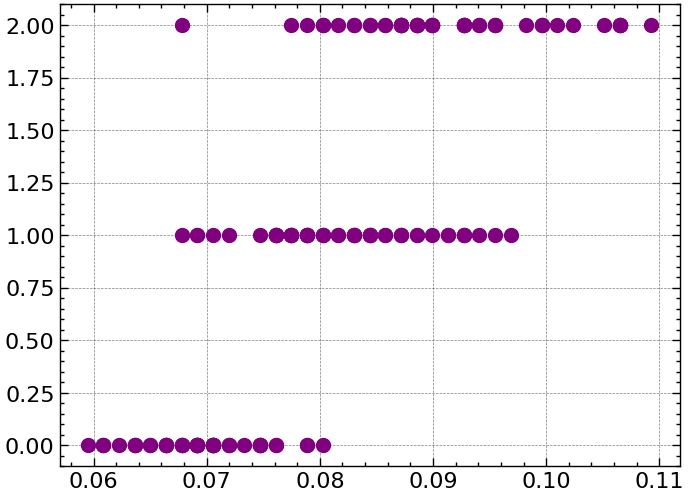

In [12]:
plt.plot(normalized_arr[:,0],target, 'o', color='purple', ms=10) #ms -> marker size

In [13]:
# Save data
elementSeparator = '\n'
parameterSeparator = ','
writeCSVData(processedData, saveFile, elementSeparator, parameterSeparator, rearrange=True)

## Train and test LIF Network

In [14]:
# Network Architecture
num_inputs = len(variablePositions)
num_hidden = 16
num_outputs = len(resultEncoding)

In [15]:
# Definitions to load the network to cuda
batch_size = 5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [16]:
# Initialize datasets for training and testing
irisDataset_train =  CustomDataset(data_path=saveFile, train=True)
irisDataset_test =  CustomDataset(data_path=saveFile, train=False)

In [17]:
print("training instances: ",len(irisDataset_train), ", ", 100*len(irisDataset_train)/(len(irisDataset_train)+len(irisDataset_test)),"%")
print("test instances: ",len(irisDataset_test), ", ", 100*len(irisDataset_test)/(len(irisDataset_train)+len(irisDataset_test)),"%")

training instances:  105 ,  70.0 %
test instances:  45 ,  30.0 %


In [18]:
# Initialize data loaders  (drop last avoids having a last batch with fewer elements)
irisDataloader_train = DataLoader(irisDataset_train, batch_size=batch_size, drop_last=True)
irisDataloader_test = DataLoader(irisDataset_test, batch_size=batch_size, drop_last=True)

In [19]:
print("training batch instances: ",len(irisDataloader_train), ", total instances ", batch_size*len(irisDataloader_train))
print("test batch instances: ",len(irisDataloader_test), ", total instances ", batch_size*len(irisDataloader_test))

training batch instances:  21 , total instances  105
test batch instances:  9 , total instances  45


In [20]:
net = NetLIF(num_inputs, num_hidden, num_outputs, batch_size, num_steps).to(device) # Load the network onto CUDA if available

In [21]:
# Training variables
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
total = 0
correct = 0 

In [22]:
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(irisDataloader_train)

    # Minibatch training loop
    for data, targets in train_batch:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, mem_rec = net(data)

        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for step in range(num_steps):
            loss_val += loss(spk_rec[step], targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print one out of every 100 computed values
        counter += 1
        if(counter % 100 == 0):  
            print(f"Train set loss: {loss_val.item()}")


Train set loss: 107.40612030029297
Train set loss: 94.30646514892578


In [23]:
with torch.no_grad():
    net.eval()
    for data, targets in irisDataloader_test:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified elements with LIF network: {correct}/{total}")
print(f"Test accuracy: {100 * correct / total:.2f}%")

Total correctly classified elements with LIF network: 30/45
Test accuracy: 66.67%


In [24]:
# Save the model
torch.save(net.state_dict(), networkFile)

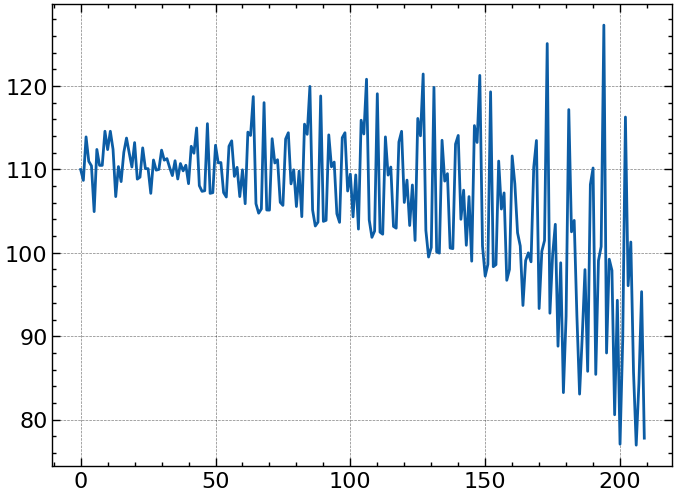

In [25]:
# Plot history loss of the model
plt.plot(loss_hist)
plt.show()

## 4.2. Train and test LIF Network

In [26]:
# Network Architecture
num_inputs = len(variablePositions)
num_hidden = 16
num_outputs = len(resultEncoding)

In [27]:
# Definitions to load the network to cuda
batch_size = 5
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

In [28]:
# Initialize datasets for training and testing
irisDataset_train =  CustomDataset(data_path=saveFile, train=True)
irisDataset_test =  CustomDataset(data_path=saveFile, train=False)

In [29]:
print("training instances: ",len(irisDataset_train), ", ", 100*len(irisDataset_train)/(len(irisDataset_train)+len(irisDataset_test)),"%")
print("test instances: ",len(irisDataset_test), ", ", 100*len(irisDataset_test)/(len(irisDataset_train)+len(irisDataset_test)),"%")

training instances:  105 ,  70.0 %
test instances:  45 ,  30.0 %


In [30]:
# Initialize data loaders  (drop last avoids having a last batch with fewer elements)
irisDataloader_train = DataLoader(irisDataset_train, batch_size=batch_size, drop_last=True)
irisDataloader_test = DataLoader(irisDataset_test, batch_size=batch_size, drop_last=True)

In [31]:
print("training batch instances: ",len(irisDataloader_train), ", total instances ", batch_size*len(irisDataloader_train))
print("test batch instances: ",len(irisDataloader_test), ", total instances ", batch_size*len(irisDataloader_test))

training batch instances:  21 , total instances  105
test batch instances:  9 , total instances  45


In [32]:
from snntorch import spikegen

# Iterate through minibatches
data = iter(irisDataloader_train)
data_it, targets_it = next(data)

# Spiking Data
spike_data = spikegen.rate(data_it, num_steps=num_steps)

In [33]:
print(spike_data.size())

torch.Size([100, 5, 4])


In [34]:
spike_data_sample2 = spike_data[:, 4, :]
spike_data_sample2

tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0.,

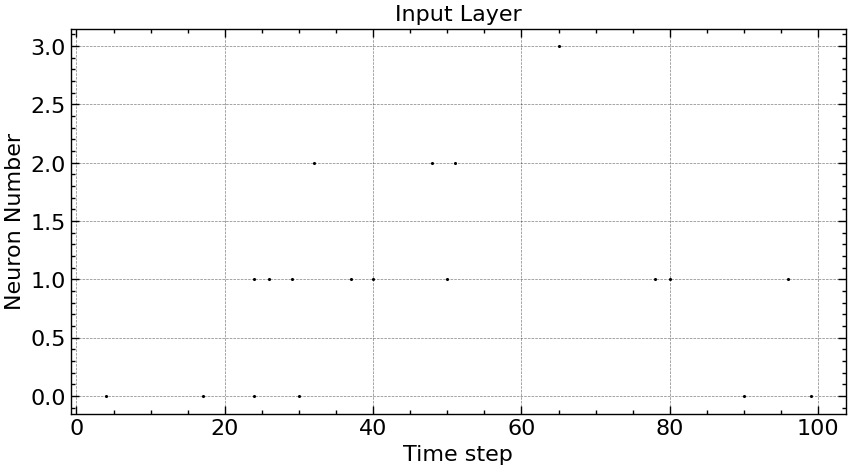

In [35]:
import snntorch.spikeplot as splt

# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

In [36]:
spike_data_sample2 = spike_data[:, 0, :]

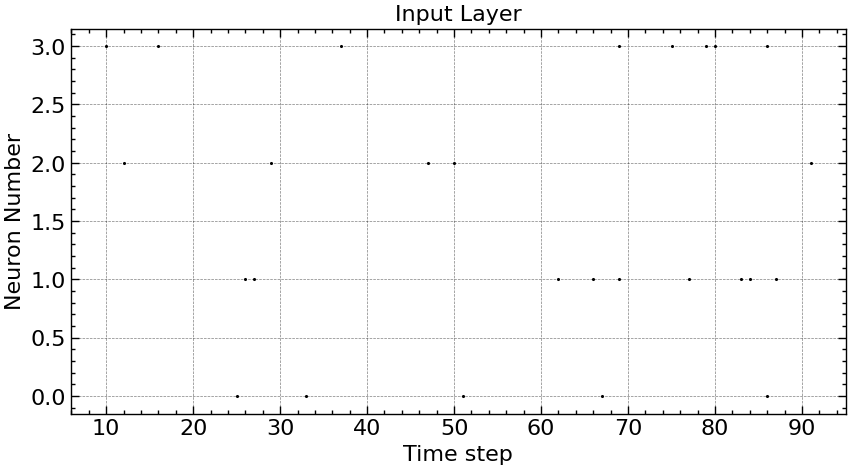

In [37]:
import snntorch.spikeplot as splt

# Reshape
spike_data_sample2 = spike_data_sample2.reshape((num_steps, -1))

# raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
splt.raster(spike_data_sample2, ax, s=1.5, c="black")

plt.title("Input Layer")
plt.xlabel("Time step")
plt.ylabel("Neuron Number")
plt.show()

In [38]:
net = NetLIFTime(num_inputs, num_hidden, num_outputs, batch_size, num_steps).to(device) # Load the network onto CUDA if available

In [39]:
# Training variables
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
total = 0
correct = 0 

In [40]:
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(irisDataloader_train)
                                                                        
    # Minibatch training loop
    for data, targets in train_batch:
        #data = data.to(device)
        targets = targets.to(device)

        spike_data = spikegen.rate(data_it, num_steps=num_steps).to(device)
        
        # forward pass
        net.train()
        spk_rec, mem_rec = net(spike_data)

        
        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        for spikes in spike_data:
            loss_val += loss(spk_rec[step], targets)
            
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print one out of every 100 computed values
        counter += 1
        if(counter % 100 == 0):  
            print(f"Train set loss: {loss_val.item()}")

        
        

Train set loss: 109.86116027832031
Train set loss: 109.86116027832031


In [41]:
with torch.no_grad():
    net.eval()
    for data, targets in irisDataloader_test:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified elements with LIF network: {correct}/{total}")
print(f"Test accuracy: {100 * correct / total:.2f}%")

Total correctly classified elements with LIF network: 22/45
Test accuracy: 48.89%


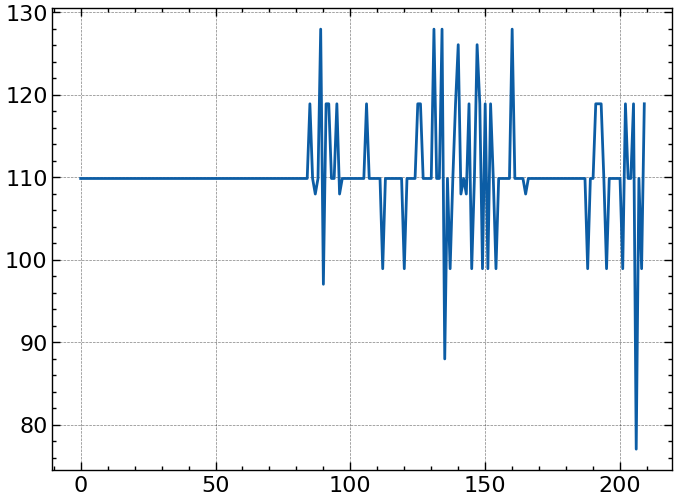

In [42]:
# Plot history loss of the model
plt.plot(loss_hist)
plt.show()

## Modification of the loss

In [43]:
net = NetLIFTimeSoft(num_inputs, num_hidden, num_outputs, batch_size, num_steps).to(device) # Load the network onto CUDA if available

In [44]:
# Training variables
num_epochs = 10
loss_hist = []
test_loss_hist = []
counter = 0
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=5e-3)
total = 0
correct = 0 

In [54]:
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(irisDataloader_train)
                                                                        
    # Minibatch training loop
    for data, targets in train_batch:
        #data = data.to(device)
        targets = targets.to(device)

        spike_data = spikegen.rate(data_it, num_steps=num_steps).to(device)
        
        # forward pass
        net.train()
        spk_rec, mem_rec, predicted = net(spike_data)
        _, predicted = predicted.max()

        print("predicted ",predicted," shape ",predicted.shape)
        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val = loss(predicted, targets)
            
        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print one out of every 100 computed values
        counter += 1
        #if(counter % 100 == 0):  
        print(f"Train set loss: {loss_val.item()}")
        
        

TypeError: iteration over a 0-d tensor

In [52]:
with torch.no_grad():
    net.eval()
    for data, targets in irisDataloader_test:
        data = data.to(device)
        targets = targets.to(device)

        spike_data = spikegen.rate(data_it, num_steps=num_steps).to(device)


        # forward pass
        test_spk, mem2, predicted = net(spike_data)
        
        print(predicted)
        print(targets)
        
        
        _, predicted = predicted.max(1)
        print(predicted)
        # calculate total accuracy
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified elements with LIF network: {correct}/{total}")
print(f"Test accuracy: {100 * correct / total:.2f}%")

tensor([[-1.3430, -0.9741, -1.0178],
        [-1.6882, -1.2764, -0.6234],
        [-1.4734, -1.2133, -0.7473],
        [-1.7753, -0.9025, -0.8556],
        [-1.4348, -0.9953, -0.9360]])
tensor([0, 1, 0, 0, 1])
tensor([1, 2, 2, 2, 2])
tensor([[-1.3482, -1.3346, -0.7401],
        [-1.1108, -1.2687, -0.9428],
        [-1.7574, -1.2784, -0.5996],
        [-1.0982, -0.8489, -1.4328],
        [-1.6553, -1.5852, -0.5041]])
tensor([0, 0, 2, 2, 0])
tensor([2, 2, 2, 1, 2])
tensor([[-1.2571, -1.1233, -0.9408],
        [-1.3244, -1.3813, -0.7282],
        [-0.9878, -1.5075, -0.9010],
        [-1.9720, -0.7675, -0.9247],
        [-1.3279, -0.7719, -1.2989]])
tensor([1, 2, 0, 0, 0])
tensor([2, 2, 2, 1, 1])
tensor([[-1.2089, -1.1369, -0.9658],
        [-1.8410, -0.8935, -0.8391],
        [-1.1491, -1.1848, -0.9748],
        [-1.1018, -1.1851, -1.0160],
        [-1.4212, -0.7537, -1.2449]])
tensor([1, 0, 0, 1, 1])
tensor([2, 2, 2, 2, 1])
tensor([[-1.3488, -1.2534, -0.7877],
        [-1.4279, -1.2364, 

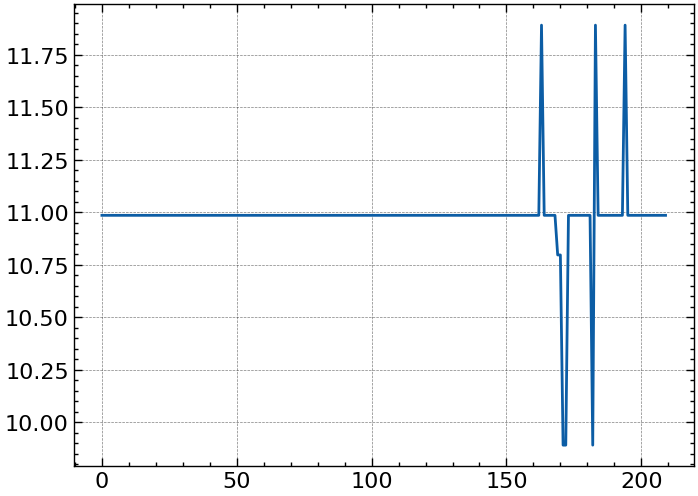

In [ ]:
# Plot history loss of the model
plt.plot(loss_hist)
plt.show()

In [ ]:
asdf

NameError: name 'asdf' is not defined

In [ ]:
# Outer training loop
for epoch in range(num_epochs):
    iter_counter = 0
    train_batch = iter(irisDataloader_train)
                                                                        
    # Minibatch training loop
    for data, targets in train_batch:
        #data = data.to(device)
        targets = targets.to(device)

        spike_data = spikegen.rate(data_it, num_steps=num_steps).to(device)
        
        # forward pass
        net.train()
        spk_rec, mem_rec = net(spike_data)
        
        print("spk_rec ",spk_rec," shape ",spk_rec.shape)

        cheik, predicted = spk_rec.sum(dim=0).max(1)
        print("predicted ",predicted," shape ",predicted.shape)
        print("cheik ",cheik," shape ",cheik.shape)
        print("targets ",targets," shape ",targets.shape)

        
        # initialize the loss & sum over time
        loss_val = torch.zeros((1), dtype=dtype, device=device)
        loss_val = loss(predicted, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Print one out of every 100 computed values
        counter += 1
        if(counter % 100 == 0):  
            print(f"Train set loss: {loss_val.item()}")

        
        

spk_rec  tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]], grad_fn=<StackBackward0>)  shape  torch.Size([100, 5, 3])
predicted  tensor([0, 0, 0, 0, 0])  shape  torch.Size([5])
cheik  tensor([0., 0., 0., 0., 0.], grad_fn=<MaxBackward0>)  shape  torch.Size([5])
targets  tensor([2, 2, 0, 0, 1])  shape  torch.Size([5])


RuntimeError: Expected floating point type for target with class probabilities, got Long

In [ ]:
with torch.no_grad():
    net.eval()
    for data, targets in irisDataloader_test:
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        test_spk, _ = net(data.view(data.size(0), -1))

        # calculate total accuracy
        _, predicted = test_spk.sum(dim=0).max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f"Total correctly classified elements with LIF network: {correct}/{total}")
print(f"Test accuracy: {100 * correct / total:.2f}%")

Total correctly classified elements with LIF network: 15/45
Test accuracy: 33.33%


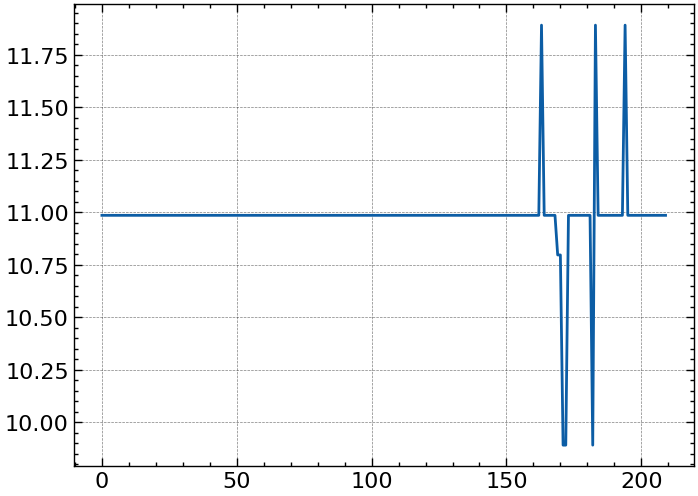

In [ ]:
# Plot history loss of the model
plt.plot(loss_hist)
plt.show()